In [1]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

In [2]:
np.random.seed(42)

(x_train_full, y_train_full), (x_test_full, y_test_full) = keras.datasets.mnist.load_data()

train_3_mask = (y_train_full == 3)
train_8_mask = (y_train_full == 8)
x_train_3_8 = x_train_full[train_3_mask | train_8_mask]
y_train_3_8 = y_train_full[train_3_mask | train_8_mask]

test_3_mask = (y_test_full == 3)
test_8_mask = (y_test_full == 8)
x_test_3_8 = x_test_full[test_3_mask | test_8_mask]
y_test_3_8 = y_test_full[test_3_mask | test_8_mask]

x_train_3_8_norm = x_train_3_8.astype('float32') / 255.0
x_test_3_8_norm = x_test_3_8.astype('float32') / 255.0

y_train_3_8_binary = (y_train_3_8 == 8).astype(np.int32)
y_test_3_8_binary = (y_test_3_8 == 8).astype(np.int32)

x_train_raw, x_val_raw, y_train, y_val = train_test_split(
    x_train_3_8_norm, y_train_3_8_binary,
    test_size=0.2,
    stratify=y_train_3_8_binary,
    random_state=42
)

x_test_final_raw = x_test_3_8_norm
y_test_final = y_test_3_8_binary

x_train = x_train_raw.reshape(x_train_raw.shape[0], -1)
x_val = x_val_raw.reshape(x_val_raw.shape[0], -1)
x_test_final = x_test_final_raw.reshape(x_test_final_raw.shape[0], -1)

print(f"Total training samples (3s & 8s): {x_train_3_8_norm.shape[0]}")
print(f"Training samples after split (flattened): {x_train.shape[0]} samples, {x_train.shape[1]} features")
print(f"Validation samples (flattened): {x_val.shape[0]} samples, {x_val.shape[1]} features")
print(f"Test samples (flattened): {x_test_final.shape[0]} samples, {x_test_final.shape[1]} features")
print("Data preprocessing complete.\n")

Total training samples (3s & 8s): 11982
Training samples after split (flattened): 9585 samples, 784 features
Validation samples (flattened): 2397 samples, 784 features
Test samples (flattened): 1984 samples, 784 features
Data preprocessing complete.



In [3]:
def evaluate_model_metrics(model, x_data, y_true_data, model_name="Model", class_labels=[3, 8]):

    print(f"\n--- Detailed Evaluation for {model_name} ---")

    y_pred_binary_classes = model.predict(x_data)

    if hasattr(model, 'predict_proba') and model.probability:
        y_pred_proba = model.predict_proba(x_data)[:, 1]
    else:
        y_pred_proba = model.decision_function(x_data)

    accuracy = model.score(x_data, y_true_data)
    precision = precision_score(y_true_data, y_pred_binary_classes)
    recall = recall_score(y_true_data, y_pred_binary_classes)
    f1 = f1_score(y_true_data, y_pred_binary_classes)

    try:
        roc_auc = roc_auc_score(y_true_data, y_pred_proba)
    except ValueError as e:
        print(f"Warning: Could not calculate ROC AUC ({e}). This might happen if only one class is present in y_true or y_score.")
        roc_auc = np.nan

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true_data, y_pred_binary_classes, target_names=[f'Class {class_labels[0]}', f'Class {class_labels[1]}']))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true_data, y_pred_binary_classes)
    print(cm)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'y_pred_proba': y_pred_proba
    }
    return metrics

In [4]:
print("\n--- Starting SVM Hyperparameter Tuning with HalvingGridSearchCV ---")

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}

svm_model = SVC(random_state=42, probability=True)

halving_search = HalvingGridSearchCV(
    estimator=svm_model,
    param_grid=param_grid,
    cv=3,
    factor=2,
    verbose=2,
    n_jobs=-1,
    scoring='accuracy'
)

print("Fitting HalvingGridSearchCV... This may take some time.")
start_time_tuning = time.time()
halving_search.fit(x_train, y_train)
end_time_tuning = time.time()
tuning_time = end_time_tuning - start_time_tuning

print(f"\nHalvingGridSearchCV fitting complete. Tuning Time: {tuning_time:.2f} seconds")

best_svm_hps = halving_search.best_params_
best_svm_score = halving_search.best_score_
best_svm_model = halving_search.best_estimator_

print(f"\nBest hyperparameters found by HalvingGridSearchCV: {best_svm_hps}")
print(f"Best cross-validation accuracy: {best_svm_score:.4f}")



--- Starting SVM Hyperparameter Tuning with HalvingGridSearchCV ---
Fitting HalvingGridSearchCV... This may take some time.
n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 299
max_resources_: 9585
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 60
n_resources: 299
Fitting 3 folds for each of 60 candidates, totalling 180 fits
----------
iter: 1
n_candidates: 30
n_resources: 598
Fitting 3 folds for each of 30 candidates, totalling 90 fits
----------
iter: 2
n_candidates: 15
n_resources: 1196
Fitting 3 folds for each of 15 candidates, totalling 45 fits
----------
iter: 3
n_candidates: 8
n_resources: 2392
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 4
n_candidates: 4
n_resources: 4784
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 5
n_candidates: 2
n_resources: 9568
Fitting 3 folds for each of 2 candidates, totalling 6 fits

HalvingGridSearchCV fitting complete. Tuning 

In [5]:
print("\n--- Final Evaluation of Best Tuned SVM Model (on Test Set) ---")
final_svm_eval_metrics = evaluate_model_metrics(best_svm_model, x_test_final, y_test_final, model_name="Final Best SVM Model")
print("\nFinal Tuned SVM Model Metrics Summary:\n")

print(pd.Series(final_svm_eval_metrics).drop(['confusion_matrix', 'y_pred_proba'], errors='ignore'))


--- Final Evaluation of Best Tuned SVM Model (on Test Set) ---

--- Detailed Evaluation for Final Best SVM Model ---
  Accuracy: 0.9940
  Precision: 0.9938
  Recall: 0.9938
  F1-Score: 0.9938
  ROC AUC: 0.9998

Classification Report:
              precision    recall  f1-score   support

     Class 3       0.99      0.99      0.99      1010
     Class 8       0.99      0.99      0.99       974

    accuracy                           0.99      1984
   macro avg       0.99      0.99      0.99      1984
weighted avg       0.99      0.99      0.99      1984


Confusion Matrix:
[[1004    6]
 [   6  968]]

Final Tuned SVM Model Metrics Summary:

accuracy     0.993952
precision     0.99384
recall        0.99384
f1_score      0.99384
roc_auc      0.999844
dtype: object


In [6]:
print("\n--- Robustness Check: Running Best SVM Model with Different Random Seeds ---")

final_svm_experiment_configs = [
    {**best_svm_hps, 'random_state': 101},
    {**best_svm_hps, 'random_state': 202},
    {**best_svm_hps, 'random_state': 303},
]

all_final_svm_results = []
all_final_svm_models = {}

for i, exp_config in enumerate(final_svm_experiment_configs):
    print(f"\n--- Running SVM Experiment {i+1} (Seed: {exp_config['random_state']}) ---")

    current_svm_model = SVC(probability=True, **exp_config)

    start_time_exp = time.time()
    current_svm_model.fit(x_train, y_train)
    end_time_exp = time.time()
    training_time_exp = end_time_exp - start_time_exp

    metrics = evaluate_model_metrics(current_svm_model, x_test_final, y_test_final,
                                     model_name=f"SVM Run (Seed: {exp_config['random_state']})")

    results = {
        'C': exp_config['C'],
        'gamma': exp_config['gamma'],
        'kernel': exp_config['kernel'],
        'random_seed': exp_config['random_state'],
        'training_time_sec': training_time_exp,
        **metrics # Include all metrics, including confusion_matrix and y_pred_proba
    }
    all_final_svm_results.append(results)
    all_final_svm_models[f'svm_exp_{i}'] = current_svm_model

final_svm_results_df = pd.DataFrame([{k: v for k, v in res.items() if k not in ['confusion_matrix', 'y_pred_proba']} for res in all_final_svm_results])
print("\nFinal SVM Experiment Results Summary (Robustness Check):\n")
print(final_svm_results_df)


--- Robustness Check: Running Best SVM Model with Different Random Seeds ---

--- Running SVM Experiment 1 (Seed: 101) ---

--- Detailed Evaluation for SVM Run (Seed: 101) ---
  Accuracy: 0.9940
  Precision: 0.9938
  Recall: 0.9938
  F1-Score: 0.9938
  ROC AUC: 0.9998

Classification Report:
              precision    recall  f1-score   support

     Class 3       0.99      0.99      0.99      1010
     Class 8       0.99      0.99      0.99       974

    accuracy                           0.99      1984
   macro avg       0.99      0.99      0.99      1984
weighted avg       0.99      0.99      0.99      1984


Confusion Matrix:
[[1004    6]
 [   6  968]]

--- Running SVM Experiment 2 (Seed: 202) ---

--- Detailed Evaluation for SVM Run (Seed: 202) ---
  Accuracy: 0.9940
  Precision: 0.9938
  Recall: 0.9938
  F1-Score: 0.9938
  ROC AUC: 0.9998

Classification Report:
              precision    recall  f1-score   support

     Class 3       0.99      0.99      0.99      1010
     Cla


--- Generating Confusion Matrix for the Best SVM Model ---


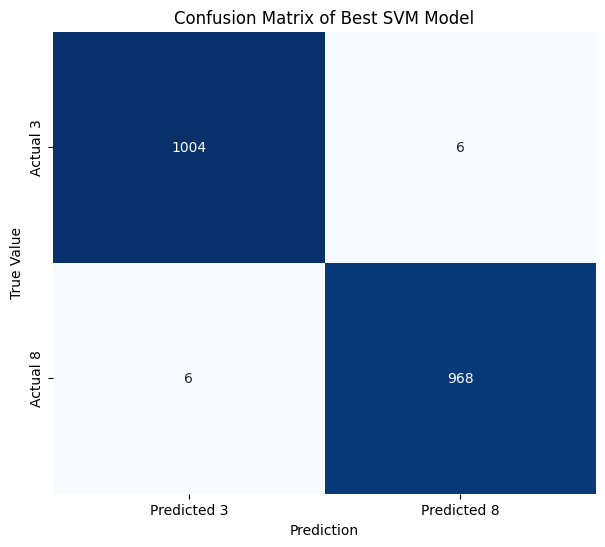

In [7]:
print("\n--- Generating Confusion Matrix for the Best SVM Model ---")
cm_svm_final = final_svm_eval_metrics['confusion_matrix']
plt.figure(figsize=(7, 6))
sns.heatmap(cm_svm_final, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 3', 'Predicted 8'], yticklabels=['Actual 3', 'Actual 8'])
plt.title('Confusion Matrix of Best SVM Model')
plt.xlabel('Prediction')
plt.ylabel('True Value')
plt.show()


--- Generating ROC Curve for the Best SVM Model ---


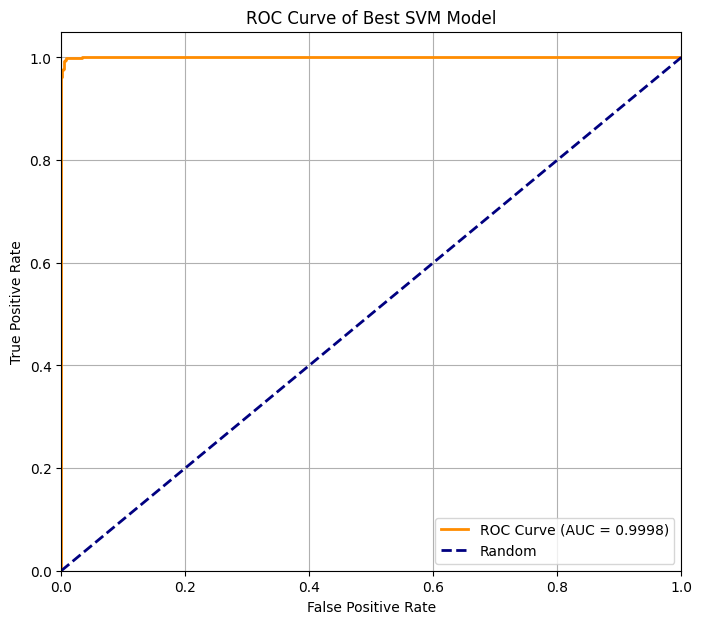

In [8]:
print("\n--- Generating ROC Curve for the Best SVM Model ---")
y_pred_proba_svm_final = final_svm_eval_metrics['y_pred_proba']
fpr_svm_final, tpr_svm_final, _ = roc_curve(y_test_final, y_pred_proba_svm_final)
roc_auc_svm_final = auc(fpr_svm_final, tpr_svm_final)

plt.figure(figsize=(8, 7))
plt.plot(fpr_svm_final, tpr_svm_final, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc_svm_final:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Best SVM Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


--- Generating Graphs for Final SVM Experiments (Robustness Check) ---

--- Detailed Evaluation for SVM Run (Seed: 101) ---
  Accuracy: 0.9940
  Precision: 0.9938
  Recall: 0.9938
  F1-Score: 0.9938
  ROC AUC: 0.9998

Classification Report:
              precision    recall  f1-score   support

     Class 3       0.99      0.99      0.99      1010
     Class 8       0.99      0.99      0.99       974

    accuracy                           0.99      1984
   macro avg       0.99      0.99      0.99      1984
weighted avg       0.99      0.99      0.99      1984


Confusion Matrix:
[[1004    6]
 [   6  968]]


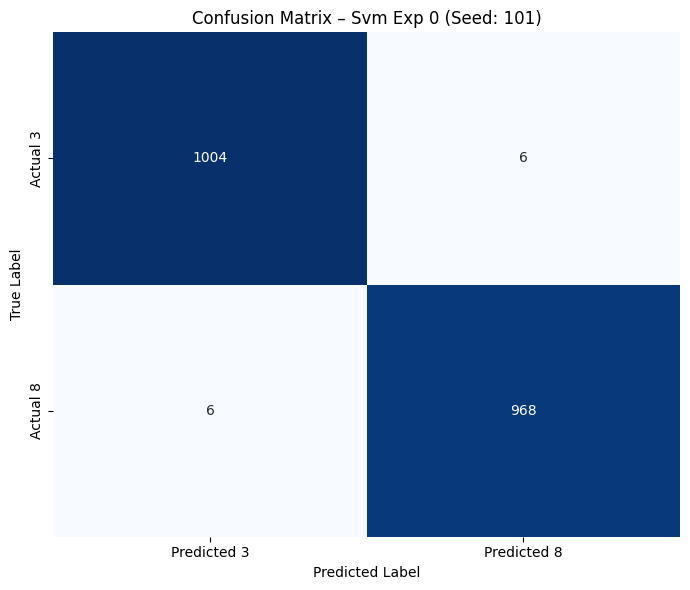

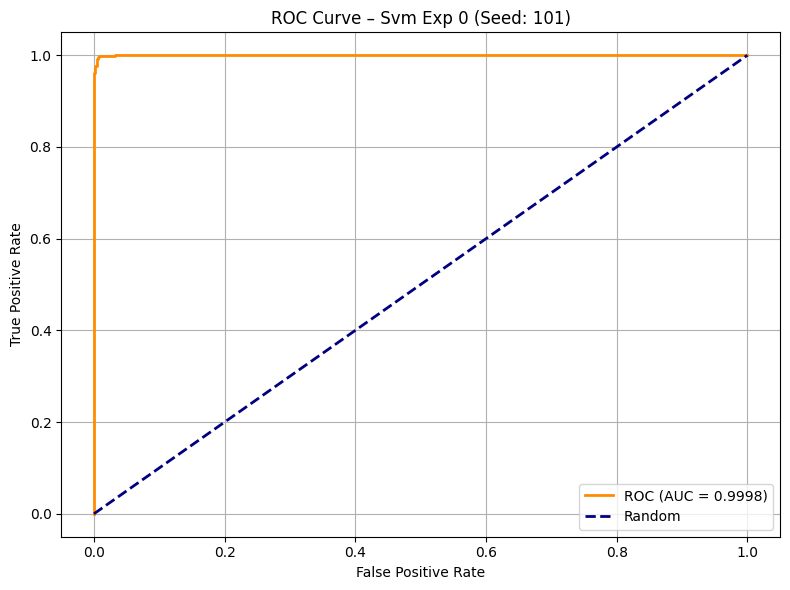


--- Detailed Evaluation for SVM Run (Seed: 202) ---
  Accuracy: 0.9940
  Precision: 0.9938
  Recall: 0.9938
  F1-Score: 0.9938
  ROC AUC: 0.9998

Classification Report:
              precision    recall  f1-score   support

     Class 3       0.99      0.99      0.99      1010
     Class 8       0.99      0.99      0.99       974

    accuracy                           0.99      1984
   macro avg       0.99      0.99      0.99      1984
weighted avg       0.99      0.99      0.99      1984


Confusion Matrix:
[[1004    6]
 [   6  968]]


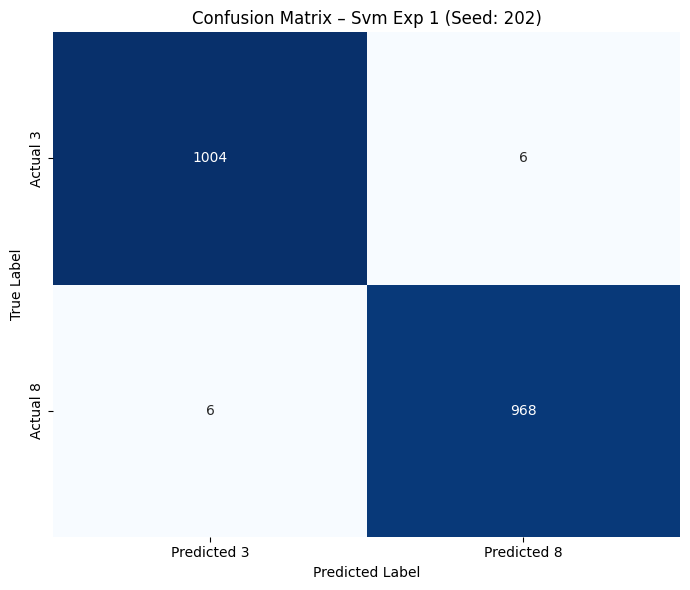

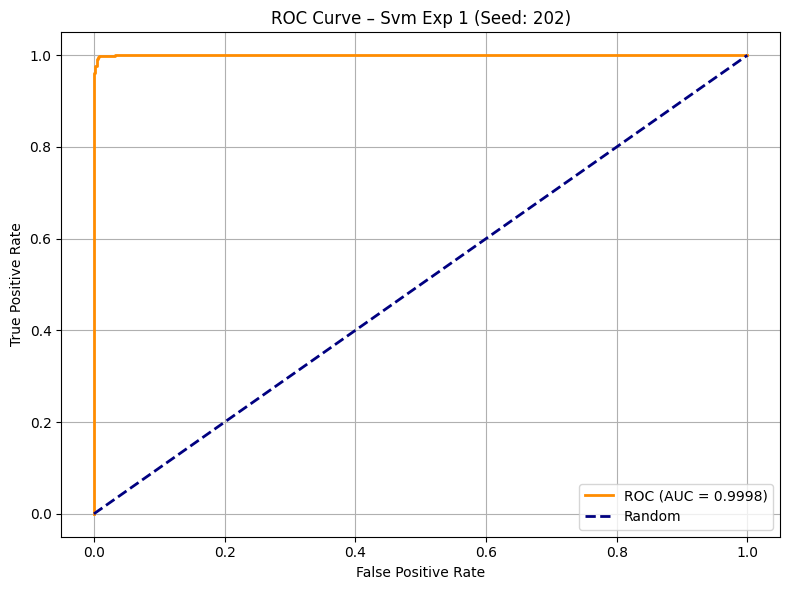


--- Detailed Evaluation for SVM Run (Seed: 303) ---
  Accuracy: 0.9940
  Precision: 0.9938
  Recall: 0.9938
  F1-Score: 0.9938
  ROC AUC: 0.9998

Classification Report:
              precision    recall  f1-score   support

     Class 3       0.99      0.99      0.99      1010
     Class 8       0.99      0.99      0.99       974

    accuracy                           0.99      1984
   macro avg       0.99      0.99      0.99      1984
weighted avg       0.99      0.99      0.99      1984


Confusion Matrix:
[[1004    6]
 [   6  968]]


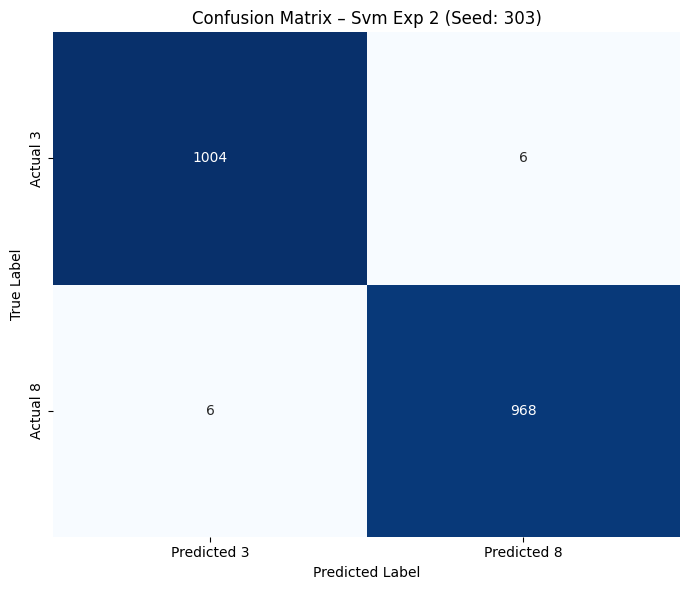

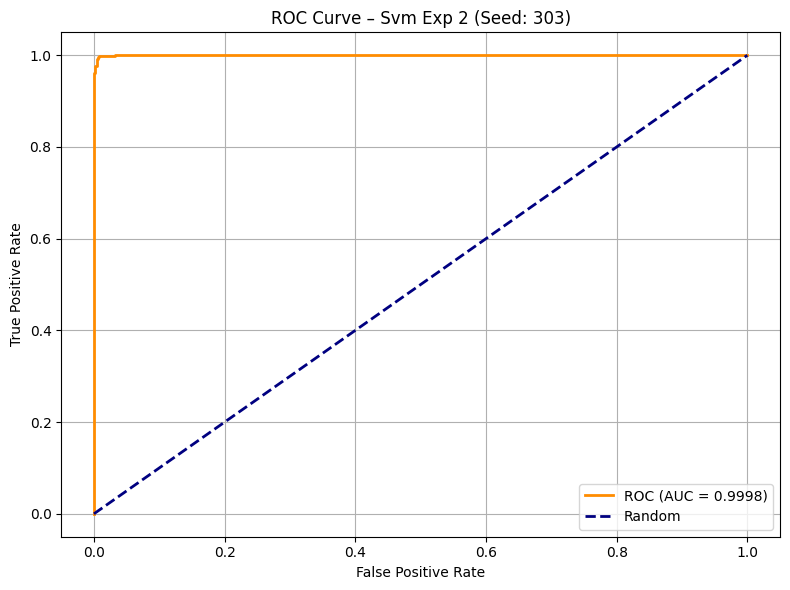

In [9]:

print("\n--- Generating Graphs for Final SVM Experiments (Robustness Check) ---")

for i, exp_config in enumerate(final_svm_experiment_configs):
    exp_name = f"svm_exp_{i}"
    model_for_prediction = all_final_svm_models[exp_name]

    #  Évaluation avec métriques complètes
    metrics = evaluate_model_metrics(
        model_for_prediction,
        x_test_final,
        y_test_final,
        model_name=f"SVM Run (Seed: {exp_config['random_state']})"
    )

    #  Matrice de confusion
    cm_exp = metrics['confusion_matrix']
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm_exp, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 3', 'Predicted 8'],
                yticklabels=['Actual 3', 'Actual 8'])
    plt.title(f'Confusion Matrix – {exp_name.replace("_", " ").title()} (Seed: {exp_config["random_state"]})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    #  Courbe ROC
    y_pred_proba_exp = metrics['y_pred_proba']
    fpr_exp, tpr_exp, _ = roc_curve(y_test_final, y_pred_proba_exp)
    roc_auc_exp = auc(fpr_exp, tpr_exp)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_exp, tpr_exp, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc_exp:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='navy', lw=2, label='Random')
    plt.title(f'ROC Curve – {exp_name.replace("_", " ").title()} (Seed: {exp_config["random_state"]})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
